---
# IMPORT

In [5]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from IPython.display import clear_output

---
# VARIABLES

- Categorized data folder tree:

    data_cater                        
    ├─ Anger              
    ├─ Disgust                    
    ├─ Fear             
    ├─ Happiness         
    ├─ Neutral    
    ├─ Sadness             
    └─ Surprise            

In [18]:
EPOCHS = 100
batch_size = 64
data_cater = 'data_last'
data_link = 'data_2'
model_name = 'EmotionModelBest.h5'
mapping = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4:'Neutral', 5:'Sadness', 6:'Surprise'}
size_image = (48, 48)
label_file_csv = 'last_label.csv'

---
# LOAD DATA FROM CATEGORRIZED - FOLDER

- Uncategorized data folder tree:

    data_link                       
    ├─ img1.png              
    ├─ img2.png                   
    ├─ img3.png         
    ├─ img4.png         
    ├─ img5.png   
    ├─ img6.png            
    └─ ...            

In [ ]:
# Show data to chart
def data_visualization(classes, data):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="#Images");
    ax.grid()

# Load data to features and labels
def load_data(data_path):
    subfolders_ck = os.listdir(data_path)
    data = []
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list = os.listdir(os.path.join(data_path, category))
        
        print('Loading:', len(img_list), 'images of category', category)
        for img in img_list:
            pixels=cv2.imread(os.path.join(data_path, category, img))
            data.append(pixels)          
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels, 7)
    data = np.array(data)

    print("\nTotal number of uploaded data:", data.shape[0])
    print("Data shape:", (data.shape[1], data.shape[2], data.shape[3]))
    data_visualization(subfolders_ck, num_images_per_class)
    return data, labels

In [ ]:
data, labels = load_data(data_cater)

**Run only one version for loading data** 

---
# LOAD DATA FROM UNCATEGORRIZED DATA FOLDER 


In [9]:
def read_file_image(file_path):
    data = []
    label = []
    label_file = pd.read_csv(label_file_csv)
    for i in range(len(label_file)):
        pixels = Image.open(os.path.join(file_path, label_file.iloc[i]['file_name']))
        bbox = label_file.iloc[i]['bbox']
        bbox = ast.literal_eval(bbox)
        pixels = pixels.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
        data.append(np.array(pixels.resize(size_image)))  

        emotion = label_file.iloc[i]['emotion']
        label.append(emotion)
    le = LabelEncoder()
    labels = le.fit_transform(label)
    labels = to_categorical(labels, 7)
    return data, labels

def preprocess_data_input(data):
    processed_data = []
    for each in data:
        if len(each.shape) == 2:
            each = np.expand_dims(each, axis=-1)
            each = np.concatenate([each, each, each], axis=-1)
        elif each.shape[2] == 1:
            each = np.concatenate([each, each, each], axis=-1)
        processed_data.append(each)
    return np.array(processed_data)

In [10]:
data, labels = read_file_image(data_link)
data = preprocess_data_input(data)

---
# PROCESS

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=3)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)

In [12]:
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              horizontal_flip=True,
                              fill_mode="nearest")

In [13]:
def build_model():    
    inputs = Input(shape=(48, 48, 3))
    base_model = EfficientNetB0(include_top=False, weights='imagenet',
                                drop_connect_rate=0.33, input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(.5, name="top_dropout")(x)
    outputs = Dense(7, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

---
# TRAINING

In [14]:
with open(model_name, 'w'):
    pass
model = build_model()

# Set up for training
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)
callbacks = [checkpoint, earlystopping, rlrop]

# Training
print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size), 
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS, callbacks=callbacks)



[INFO] training network for 100 epochs...

Epoch 1/100


306/306 [==============================] - ETA: 0s - loss: 0.8686 - accuracy: 0.6919
Epoch 1: val_accuracy improved from -inf to 0.69693, saving model to EmotionModelOverFitting.h5


d:\Study\Giáo trình\AI Hackathon\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/306 [==============================] - 248s 721ms/step - loss: 0.8686 - accuracy: 0.6919 - val_loss: 0.9480 - val_accuracy: 0.6969 - lr: 0.0010
Epoch 2/100
306/306 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.7887
Epoch 2: val_accuracy improved from 0.69693 to 0.80818, saving model to EmotionModelOverFitting.h5
306/306 [==============================] - 204s 666ms/step - loss: 0.6256 - accuracy: 0.7887 - val_loss: 0.5688 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 3/100
306/306 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.8069
Epoch 3: val_accuracy improved from 0.80818 to 0.82505, saving model to EmotionModelOverFitting.h5
306/306 [==============================] - 201s 657ms/step - loss: 0.5664 - accuracy: 0.8069 - val_loss: 0.5323 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 4/100
306/306 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.8186
Epoch 4: val_accuracy improved from 0.82505 to 0.82957, saving mode

---
# PREDICT AND EVALUATE

In [19]:
model = build_model()
model.load_weights(model_name)
clear_output()
model

In [21]:
predict = model.predict(X_test)
predict = np.argmax(np.array(predict), axis=1)
y_test = np.argmax(np.array(y_test), axis=1)

print("Accuracy : " + str(accuracy_score(y_test, predict)))

132/132 [==============================] - 11s 84ms/step
Accuracy : 0.5570342205323194


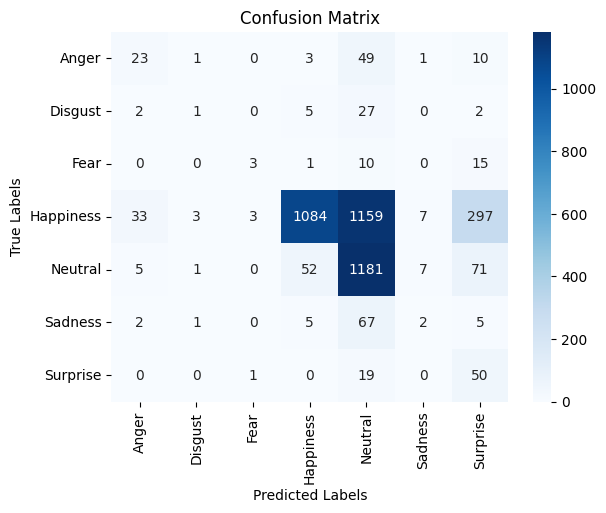

In [22]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predict)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mapping.values(), yticklabels=mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()